# Examples and tutorial for Variational Bayesian Monte Carlo

In [1]:
import numpy as np
from pyvbmc.vbmc import VBMC

## Example 1: Basic usage
Simple usage of VBMC having as target log likelihood <a href="https://en.wikipedia.org/wiki/Rosenbrock_function">Rosenbrock''s banana function</a>.

In [2]:
# We consider a 2-D problem
D = 2

We set as toy log likelihood for our model a broad Rosenbrock's banana function in 2D (see https://en.wikipedia.org/wiki/Rosenbrock_function).

In [3]:
# log likelihood of your model
def llfun(x):
    x = np.atleast_2d(x)
    return -np.sum(
                (x[0, :-1] ** 2.0 - x[0, 1:]) ** 2.0
                + (x[0, :-1] - 1) ** 2.0 / 100
            )

We define now a prior over the parameters (for simplicity, independent Gaussian prior on each variable, but you could do whatever).

In [4]:
prior_mu = np.zeros((1,D))
prior_var = 3**2*np.ones((1,D))
lpriorfun = lambda x: (-0.5*np.sum((x-prior_mu)**2 / prior_var,axis=1)
                        -0.5*np.log(np.prod(2*np.pi*prior_var)))

So our log joint (that is, unnormalized log posterior density), is:

In [5]:
fun = lambda x: llfun(x) + lpriorfun(x)

We assume an unconstrained domain for the model parameters, and finite plausible bounds which should denote a region of high posterior  probability mass. Not knowing better, we use mean +/- 1 SD of the prior (that is, the top ~68% prior credible interval) to set plausible bounds.

In [6]:
LB = -np.full((1,D), np.inf)                 # Lower bounds
UB = np.full((1,D), np.inf)                  # Upper bounds
PLB = prior_mu - np.sqrt(prior_var)          # Plausible lower bounds
PUB = prior_mu + np.sqrt(prior_var)          # Plausible upper bounds

Analogously, you could set the plausible bounds using the quantiles:
```
from scipy.stats import norm
PLB = norm.ppf(0.1587,prior_mu,np.sqrt(prior_var))
PUB = norm.ppf(0.8413,prior_mu,np.sqrt(prior_var))
```

In [7]:
# As a starting point, we use the mean of the prior:
x0 = np.copy(prior_mu)

Alternatively, we could have used a sample from inside the plausible box:
```
x0 = PLB + np.random.uniform(size=(1,D))*(PUB - PLB)
```

We now initialize the VBMC object.  For now, we use default options for the inference.

In [8]:
vbmc = VBMC(fun, x0, LB, UB, PLB, PUB)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Run vbmc.optimize(), which returns the variational posterior VP, the lower bound on the log model evidence ELBO, and its uncertainty ELBO_SD.

In [ ]:
vp, elbo, elbo_sd, _, _ = vbmc.optimize()

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10          18.33       174.82    461739.72        2        inf     start warm-up
     1         15           5.90        18.81         0.37        2        inf     
     2         20          -2.80         0.00       209.26        2   4.96e+03     
     3         25          -2.80         0.01         0.03        2      0.615     
     4         30          -2.78         0.02         0.02        2      0.474     end warm-up
     5         35          -2.74         0.00         0.22        2       5.21     
     6         40          -2.71         0.00         0.01        2       0.26     
     7         45          -2.65         0.00         0.01        5      0.331     
     8         50          -2.58         0.00         0.07        8       1.98     
     9         55          -2.57         0.00    

The true log model evidence is lnZ = -2.272.
Note that:
1) The ELBO is a lower bound on the true log model evidence.
2) The reported standard deviation of the ELBO is a measure of the uncertainty on the ELBO as estimated via Bayesian quadrature (the approximation technique used by VBMC). It is NOT a measure of the difference between the ELBO and the true log model evidence,which is generally unknown. 

In [ ]:
print("The obtained ELBO is:", elbo)
print("The obtained ELBO_SD is:", elbo_sd)

The obtained ELBO is: -2.3548082537956274
The obtained ELBO_SD is: 0.001454141156917816


Note that VBMC does not aim for high numerical precision (e.g., beyond the 1st or 2nd decimal place). In most realistic model-fitting problems, a higher resolution is not particularly useful.

We can now examine the obtained variational posterior.

In [ ]:
# First, let us generate a million samples from the variational posterior:
n_samples = int(3e5)
Xs, _ = vp.sample(n_samples)

In [ ]:
# Easily compute statistics such as moments, credible intervals, etc.
post_mean = np.mean(Xs,axis=0)             # Posterior mean
post_cov = np.cov(Xs.T)                    # Posterior covariance matrix
print("The approximate posterior mean is:", post_mean)
print("The approximate posterior covariance matrix is\n", post_cov)

The approximate posterior mean is: [0.13149412 1.0502766 ]
The approximate posterior covariance matrix is
 [[1.09031879 0.40602356]
 [0.40602356 1.64591767]]


For reporting uncertainty on model parameter estimates, you could use posterior mean +/- SD, or the median and interquartile range (the latter is better for a posterior that deviates substantially from Gaussian).

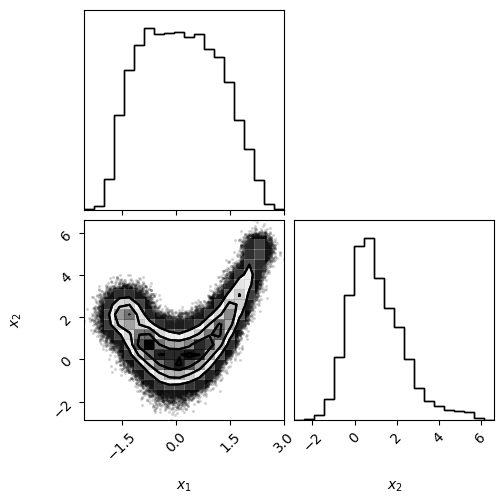

In [ ]:
# We visualize the posterior marginals using the CORNERPLOT function:
import matplotlib.pyplot as plt
import corner

# plot all sampled points
plt.rcParams['agg.path.chunksize'] = n_samples

figure = corner.corner(Xs)
corner.corner(Xs, fig=figure, labels=['$x_1$', '$x_2$'])
plt.show()

## Example 2: Bound parameters
As in Example 1, but we assume parameters are constrained to be positive. We also display the evolution of the variational posterior in each iteration.

*(In the plots, black circles represent points in the training set,and red circles points added to the training set in this iteration.)*

In [ ]:
# log likelihood (rosenbrock)
def llfun(x):
    x = np.atleast_2d(x)
    return -np.sum(
                (x[0, :-1] ** 2.0 - x[0, 1:]) ** 2.0
                + (x[0, :-1] - 1) ** 2.0 / 100
            )

# still in 2-D
D = 2

Since parameters are positive, we impose an exponential prior.

In [ ]:
prior_tau = 3*np.ones((1,D))            # Length scale of the exponential prior
lpriorfun = lambda x: -np.sum(x/prior_tau) -np.log(np.prod(prior_tau))

# Log joint
fun = lambda x: llfun(x) + lpriorfun(x)        

Bound settings require some discussion:
1) the specified bounds are **NOT** included in the domain, so in this case, 
   since we want to be the parameters to be positive, we can set LB = 0, 
   knowing that the parameter will always be greater than zero.

In [ ]:
LB = np.zeros((1,D))                           # Lower bounds

2) Currently, VBMC does not support half-bounds, so we need to specify
    a finite upper bound (cannot be Inf). We pick something very large
    according to our prior. However, do not go crazy here by picking 
    something impossibly large, otherwise VBMC will fail.

In [ ]:
UB = 10*prior_tau                              # Upper bounds

3) Plausible bounds need to be meaningfully different from hard bounds,
so here we cannot pick PLB = 0. We follow the same strategy as the first
   example, by picking the top ~68% credible interval of the prior.

In [ ]:
PLB = 0.1728*prior_tau         # PLB = expinv(0.1587,prior_tau)
PUB = 1.8407*prior_tau         # PUB = expinv(0.8413,prior_tau)

Good practice is to initialize VBMC in a region of high posterior density. For this example, we cheat and start in the proximity of the mode, which is near the optimum of the likelihood (which we know).

In [ ]:
x0 = np.ones((1,D))             # Optimum of the Rosenbrock function

In [ ]:
# init VBMC
#user_options = {"plot": True}
vbmc = VBMC(fun, x0, LB, UB, PLB, PUB)#, user_options)

In [ ]:
# run VBMC
vp, elbo, elbo_sd, _, _ = vbmc.optimize()

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10       15654.14     39771.12    178149.63        2        inf     start warm-up
     1         15          26.63       678.68     31461.33        2        inf     
     2         20         818.17      1241.93       167.45        2   1.07e+04     
     3         25       11821.81      6932.48     26486.14        2   6.84e+05     
     4         30         -10.32        11.05     18279.86        2   4.66e+05     trim data
     5         35          80.69        79.11        89.57        2   2.68e+03     
     6         40          89.15        43.98        27.78        2        819     end warm-up
     7         45          -2.89         0.07       446.78        2   1.08e+04     
     8         50          -2.74         0.04         0.07        2       2.29     
     9         55          53.86       2

The true log model evidence is lnZ = -1.836.

We will examine now the obtained variational posterior.

In [ ]:
# Generate samples from the variational posterior
Xs, _ = vp.sample(n_samples)

In [ ]:
# We compute the pdf of the approximate posterior on a 2-D grid
plot_lb = np.zeros(2)
plot_ub = np.quantile(Xs,0.999, axis=0)
x1 = np.linspace(plot_lb[0],plot_ub[0],400)
x2 = np.linspace(plot_lb[1],plot_ub[1],400)

xa, xb = np.meshgrid(x1,x2)                 # Build the grid
xx = np.vstack((xa.ravel(), xb.ravel())).T  # Convert grids to a vertical array of 2-D points
yy = vp.pdf(xx)                             # Compute PDF values on specified points

/home/marlon/hy/vbmc/pyvbmc/pyvbmc/parameter_transformer/parameter_transformer.py:128: RuntimeWarning: divide by zero encountered in log
  u[:, mask] = np.log(np.divide(z, (1 - z)))
/home/marlon/hy/vbmc/pyvbmc/pyvbmc/parameter_transformer/parameter_transformer.py:229: RuntimeWarning: invalid value encountered in add
  np.log(self.ub_orig - self.lb_orig) - u_c[:, mask] + 2 * z


In [ ]:
# Plot approximate posterior pdf (works only in 1-D and 2-D)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x1,x2,yy.reshape(x1.size,x2.size))
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("Approximate posterior pdf")
#set(gca,'TickDir','out');
#set(gcf,'Color','w');

<ipython-input-24-13b41e3c9eae>:3: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(x1,x2,yy.reshape(x1.size,x2.size))


Text(0.5, 0, 'Approximate posterior pdf')

/home/marlon/hy/vbmc/pyvbmc/pyvbmc/parameter_transformer/parameter_transformer.py:128: RuntimeWarning: invalid value encountered in log
  u[:, mask] = np.log(np.divide(z, (1 - z)))
/home/marlon/hy/vbmc/pyvbmc/pyvbmc/variational_posterior/variational_posterior.py:451: RuntimeWarning: divide by zero encountered in log
  y = np.log(y)


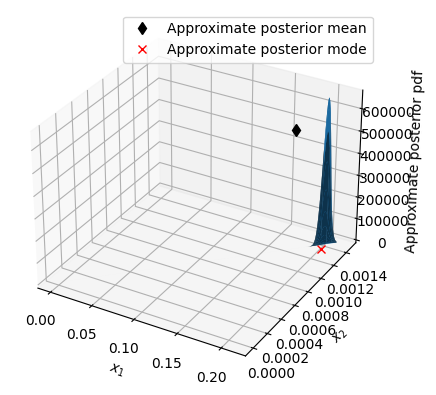

In [ ]:
# Compute and plot approximate posterior mean
post_mean = np.mean(Xs, axis=0)
ax.plot(post_mean[0],post_mean[1],vp.pdf(post_mean)[0], 'dk', label="Approximate posterior mean")

# Find and plot approximate posterior mode
post_mode = vp.mode()
ax.plot(post_mode[0],post_mode[1],vp.pdf(post_mode)[0], 'xr', label="Approximate posterior mode")
ax.legend()
plt.show()